In [28]:
import os
import numpy as np
import imageio
import cv2
import PIL.Image as pil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
sys.path.append('../')

import torch
from torchvision import transforms

import networks

from experiment_utils import *

In [40]:
# load image
pose_dir = '/viscompfs/users/tedyu/ScanNet/poses/'
seq_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'
# scene_num = 'scene0001_00'
# tgt_num = 300
# frame_offset = 15
# scene_num = 'scene0105_00'
# tgt_num = 1100
# frame_offset = 15
scene_num = 'scene0358_00'
tgt_num = 300
frame_offset = 15
src_num = tgt_num + frame_offset

Image shape: (968, 1296, 3) 

Scaled image shape: (256, 320, 3) 

Source pose:
[[ 0.449133  0.350028 -0.822046  3.432303]
 [ 0.888776 -0.269165  0.370981  1.364488]
 [-0.091413 -0.897235 -0.431987  1.421679]
 [ 0.        0.        0.        1.      ]] 

Target pose:
[[ 0.588537  0.379297 -0.713974  3.258588]
 [ 0.807916 -0.308622  0.50202   1.266741]
 [-0.029934 -0.872288 -0.488075  1.39918 ]
 [ 0.        0.        0.        1.      ]]
Intrinsics:
[[1.17018799e+03 0.00000000e+00 6.47750000e+02]
 [0.00000000e+00 1.17018799e+03 4.83750000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Scaled intrinsics:
[[288.93530568   0.         159.9382716 ]
 [  0.         309.47120344 127.9338843 ]
 [  0.           0.           1.        ]] 

Relative pose:
[[ 0.9851241  -0.02420256  0.17013044 -0.16283963]
 [ 0.01539955  0.99848213  0.05288087 -0.01430815]
 [-0.1711519  -0.0494754   0.98400141  0.11625872]
 [ 0.          0.          0.          1.        ]] 

Mean disp: 0.000793169951481843

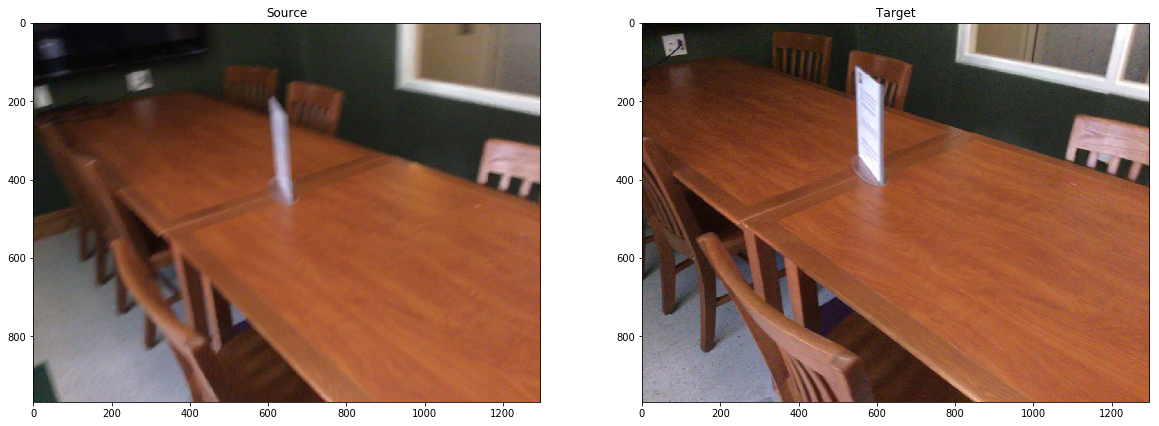

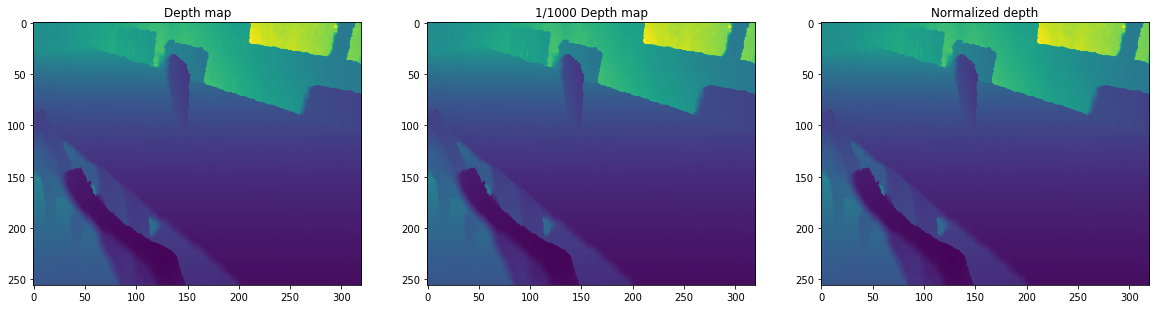

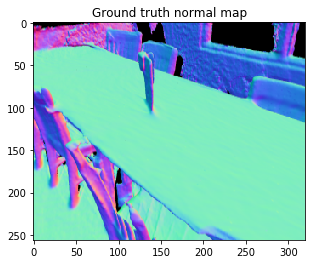

In [41]:
# read images
H, W = 256, 320
tgt_path = os.path.join(seq_dir, scene_num, 'color', str(tgt_num)+'.jpg')
src_path = os.path.join(seq_dir, scene_num, 'color', str(src_num)+'.jpg')
tgt = pil.open(tgt_path).convert('RGB')
src = pil.open(src_path).convert('RGB')
oldW, oldH = tgt.size
assert src.size == tgt.size
tgt_scaled = tgt.resize((W, H), pil.LANCZOS)
src_scaled = src.resize((W, H), pil.LANCZOS)
tgt_tensor = transforms.ToTensor()(tgt_scaled).unsqueeze(0)
src_tensor = transforms.ToTensor()(src_scaled).unsqueeze(0)
tgt_scaled = np.asarray(tgt_scaled)
src_scaled = np.asarray(src_scaled)
assert src_scaled.shape == tgt_scaled.shape
print('Image shape:', np.asarray(tgt).shape, '\n')
print('Scaled image shape:', tgt_scaled.shape, '\n')

# read pose
src_pose_path = os.path.join(pose_dir, scene_num, 'pose', str(src_num)+'.txt')
tgt_pose_path = os.path.join(pose_dir, scene_num, 'pose', str(tgt_num)+'.txt')
src_pose = np.loadtxt(src_pose_path)
tgt_pose = np.loadtxt(tgt_pose_path)
print('Source pose:')
print(src_pose, '\n')
print('Target pose:')
print(tgt_pose)

# read intrinsics
intr_path = os.path.join(seq_dir, scene_num, 'intrinsic', 'intrinsic_color.txt')
intrinsics = np.loadtxt(intr_path)
intrinsics = intrinsics[:3, :3]
intrinsics_scaled = scale_intrinsics(intrinsics, oldH, oldW, H, W)
print('Intrinsics:')
print(intrinsics, '\n')
print('Scaled intrinsics:')
print(intrinsics_scaled, '\n')

# calculate relative pose
T0 = np.zeros([4, 4])
T0[:3, :3] = src_pose[:3, :3].T @ tgt_pose[:3, :3]
T0[:3, 3] = src_pose[:3, :3].T @ (tgt_pose[:3, 3] - src_pose[:3, 3])
T0[3, 3] = 1
rel_pose = T0
print('Relative pose:')
print(rel_pose, '\n')

# read ground truth depth for target frame
#depth_path = os.path.join(seq_dir, scene_num, 'depth', str(tgt_num)+'.png')
depth_path = os.path.join(gt_dir, scene_num, 'depth_interp', str(tgt_num)+'.png')
depth = imageio.imread(depth_path)
depth = cv2.resize(depth, (W, H))
depth1000 = depth / 1000.0 # scaled by 1/1000

disp = 1/depth
mean_disp = np.mean(disp)
disp /= mean_disp
n_depth = 1/disp # normalized depth
print('Mean disp:', mean_disp)

# read ground truth surface normal
#normal_path = os.path.join(gt_dir, scene_num, 'normal', str(tgt_num)+'.png')
normal_path = os.path.join(gt_dir, "scene0358_00", 'normal', str(tgt_num)+'.png')
if os.path.exists(normal_path):
    normal_gt = imageio.imread(normal_path)
    normal_gt = cv2.resize(normal_gt, (W, H))
    print('Normal map shape:', normal_gt.shape)

# show images
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(src)
ax2.imshow(tgt)
ax1.set_title('Source')
ax2.set_title('Target')
plt.show()

# show depth maps
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(depth)
ax2.imshow(depth1000)
ax3.imshow(n_depth)
ax1.set_title('Depth map')
ax2.set_title('1/1000 Depth map')
ax3.set_title('Normalized depth')
plt.show()

# load normal map 
if not os.path.exists(normal_path):
    print('Normal map does not exist!')
else:
    plt.imshow(normal_gt)
    plt.title('Ground truth normal map')
    plt.show()

### Load model weights 

In [42]:
model_dir = "/viscompfs/users/tedyu/MonoPatch_ckpt/orth_pretrained/"
model_name = "MonoPatch_orth_1.0/models/weights_19"

encoder_path = os.path.join(model_dir, model_name, "encoder.pth")
depth_decoder_path = os.path.join(model_dir, model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

### Inference

In [43]:
with torch.no_grad():
    features = encoder(tgt_tensor)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

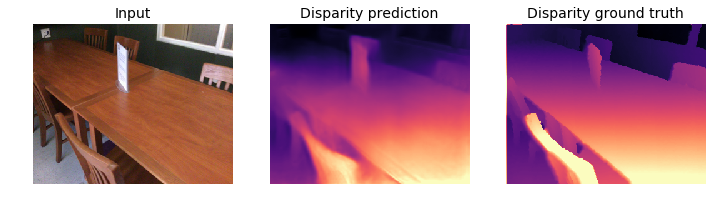

In [44]:
fs = 14 # font size

# Saving colormapped depth image
disp_resized_np = disp.squeeze().cpu().numpy()

# rescale predicted disparities
disp_gt = 1 / (depth1000 + 1e-10)
disp_rescaled = disp_resized_np * np.median(disp_gt) / np.median(disp_resized_np)
vmax = np.percentile(disp_gt, 95)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(tgt_scaled)
plt.title("Input", fontsize=fs)
plt.axis('off')

plt.subplot(132)
plt.imshow(disp_rescaled, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=fs)
plt.axis('off')

plt.subplot(133)
plt.imshow(disp_gt, cmap='magma', vmax=vmax)
plt.title("Disparity ground truth", fontsize=fs)
plt.axis('off')

plt.tight_layout()
plt.show()

### Surface normals

In [46]:
def plot_normal(normal):
    x = (normal[0, :, :] + 1) / 2
    y = (normal[1, :, :] * -1 + 1) / 2
    z = (normal[2, :, :] / 2) * -1 + 0.5

    normal = torch.stack([x, y, z], dim=0)
    return normal

In [45]:
# LOADING PRETRAINED MODEL
normal_encoder_path = os.path.join(model_dir, model_name, "normal_encoder.pth")
normal_decoder_path = os.path.join(model_dir, model_name, "normal.pth")

normal_encoder = networks.ResnetEncoder(18, False)
normal_decoder = networks.NormalDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(normal_encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() \
                     if k in normal_encoder.state_dict()}
normal_encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(normal_decoder_path, map_location='cpu')
normal_decoder.load_state_dict(loaded_dict)

normal_encoder.eval()
normal_decoder.eval();

In [47]:
with torch.no_grad():
    features = normal_encoder(tgt_tensor)
    outputs = normal_decoder(features)

normal = outputs[("norm", 0)]

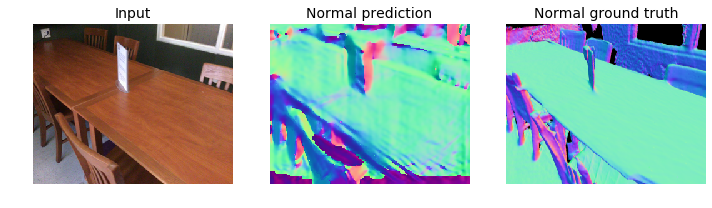

In [48]:
fs = 14 # font size

# adjust shape
normal = plot_normal(normal[0])
normal_np = normal.squeeze().cpu().numpy()
normal_np = np.transpose(normal_np, [1, 2, 0])

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(tgt_scaled)
plt.title("Input", fontsize=fs)
plt.axis('off')

plt.subplot(132)
plt.imshow(normal_np)
plt.title("Normal prediction", fontsize=fs)
plt.axis('off')

plt.subplot(133)
plt.imshow(normal_gt)
plt.title("Normal ground truth", fontsize=fs)
plt.axis('off')

plt.tight_layout()
plt.show()